In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD

# Read and preprocess the dataset

path = '../data/'  # Change this to your path
# return_series = pd.read_parquet(f'{path}usa_returns.parquet')
return_series = pd.read_csv('../data/msci_country_indices.csv', sep= ";", index_col=0 )
return_series.index = pd.to_datetime(return_series.index)
return_series_monthly = np.exp(np.log(1 + return_series).resample('M').sum()) - 1

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(return_series)
return_series_scaled = pd.DataFrame(scaler.transform(return_series),
                                    columns= return_series.columns,
                                    index= return_series.index)
num_stocks= return_series_scaled.shape[1]
print(f"Historical daily returns of {return_series.shape[1]} stocks from {return_series.head(1).index[0]} to {return_series.tail(1).index[0]}")

Historical daily returns of 24 stocks from 1999-01-01 00:00:00 to 2023-04-18 00:00:00


In [168]:
width = 100 #days
rebdate = return_series.index[width]
X_train = []
y_train = []
train_enddate = return_series.tail(width +1).index[-2]
step_day = 1

while rebdate < train_enddate:  # num_shape needs to be defined
    X_train_ = return_series_scaled[return_series_scaled.index < rebdate].tail(width).values.reshape((num_stocks,width))  # train_scaled should be defined
    X_train.append(X_train_)
    y_train.append(return_series[return_series.index >= rebdate].head(1).values[0])
    rebdate += pd.DateOffset(days=step_day)
X_train = np.stack(X_train)
y_train = np.stack(y_train)

In [169]:
X_train.shape, y_train.shape

((8732, 24, 100), (8732, 24))

### Dataset description 

For training dataset: 6815 time slices with length of 100 days 

In [126]:
# Initialize the Recurrent Neural Network (RNN) model

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(50, activation= "relu", input_shape=(num_stocks, width)))
model.add(Dropout(0.2))
model.add(Dense(num_stocks))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()
model.compile(optimizer='adam', loss='mean_squared_error')

/home/akaboshi/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 24)             │         1,224 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,424 (122.75 KB)

 Trainable params: 31,424 (122.75 KB)

 Non-trainable params: 0 (0.00 B)

In [127]:
# Fit the model
model.fit(X_train, y_train, epochs=100, verbose=2)

Epoch 1/100
273/273 - 4s - 15ms/step - loss: 0.0240
Epoch 2/100
273/273 - 1s - 3ms/step - loss: 0.0044
Epoch 3/100
273/273 - 1s - 3ms/step - loss: 0.0022
Epoch 4/100
273/273 - 1s - 3ms/step - loss: 0.0013
Epoch 5/100
273/273 - 1s - 3ms/step - loss: 0.0061
Epoch 6/100
273/273 - 1s - 3ms/step - loss: 0.0011
Epoch 7/100
273/273 - 1s - 3ms/step - loss: 5.8588e-04
Epoch 8/100
273/273 - 1s - 3ms/step - loss: 4.6915e-04
Epoch 9/100
273/273 - 1s - 3ms/step - loss: 3.9748e-04
Epoch 10/100
273/273 - 1s - 3ms/step - loss: 3.4644e-04
Epoch 11/100
273/273 - 1s - 3ms/step - loss: 3.0908e-04
Epoch 12/100
273/273 - 1s - 3ms/step - loss: 2.7618e-04
Epoch 13/100
273/273 - 1s - 3ms/step - loss: 2.5525e-04
Epoch 14/100
273/273 - 1s - 3ms/step - loss: 2.3526e-04
Epoch 15/100
273/273 - 1s - 3ms/step - loss: 2.2370e-04
Epoch 16/100
273/273 - 1s - 3ms/step - loss: 2.1419e-04
Epoch 17/100
273/273 - 1s - 3ms/step - loss: 2.1135e-04
Epoch 18/100
273/273 - 1s - 3ms/step - loss: 2.0768e-04
Epoch 19/100
273/273 - 1

In [147]:
test_size = 50
rebdate = return_series.tail(test_size +1).index[1]
X_test = []
y_test = []
prediction_dates = []
while rebdate < return_series.tail(1).index[-1]:
    X_test_ = return_series_scaled[return_series_scaled.index < rebdate].tail(width).values.reshape((num_stocks,width))
    X_test.append(X_test_)
    y_test.append(return_series[return_series.index >= rebdate].head(1).values.reshape(num_stocks, step_day))
    rebdate += pd.DateOffset(days=1)
    prediction_dates.append(return_series[return_series.index >= rebdate].index[0])
X_test = np.stack(X_test)
y_test = np.stack(y_test)

In [150]:
predicted_returns = model.predict(X_test).reshape(y_test.shape)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


<Axes: >

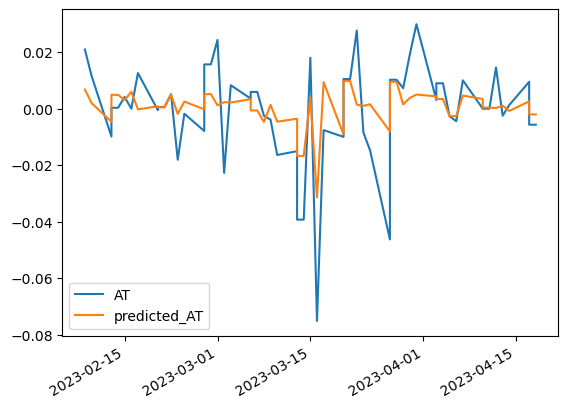

In [151]:
stock_position = 0
test = y_test[:,stock_position].reshape(-1)
prediction = predicted_returns[:,stock_position].reshape(-1)
df = pd.DataFrame({ f"{return_series.columns[stock_position]}": test,
              f"predicted_{return_series.columns[stock_position]}" : prediction},
             index= prediction_dates)
df.plot()

,prediction,benchmark,predicted_revelance,benchmark_revelance
NL,-0.003189,-0.013588,2,1
IT,-0.002834,-0.007067,3,2
AT,-0.002033,-0.005665,8,3
FR,-0.002207,-0.002323,5,4
DE,-0.002167,-0.002086,6,5
CH,-0.002068,-0.001485,7,6
SE,-0.001926,-0.000899,10,7
FI,-0.001739,-0.000671,12,8
ES,-0.002578,-0.000240,4,9
GR,-0.000672,0.000000,15,10


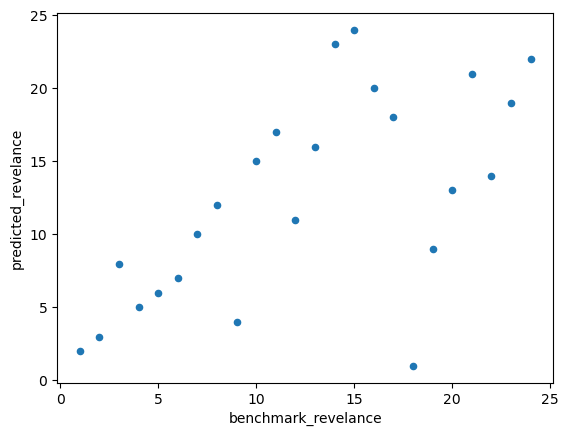

In [214]:
ranking = pd.DataFrame({"prediction": predicted_returns[-1].reshape(-1),
            #   "prediction_rank": predicted_returns[-1].reshape(-1).argsort().argsort(),
             "benchmark": y_test[-1].reshape(-1),
            #  "benchmark_rank": y_test[-1].reshape(-1).argsort().argsort()
            }, index= return_series.columns)
ranking['predicted_revelance'] = ranking["prediction"].rank(ascending=True).astype(int)
ranking['benchmark_revelance'] = ranking["benchmark"].rank(ascending=True).astype(int)

ranking.plot("benchmark_revelance" , "predicted_revelance", kind = "scatter")
ranking.sort_values("benchmark_revelance")

## Save model 

In [195]:
# Save the entire model as a `.keras` zip archive.
path_model = f"../model/lstm_msci.keras"
model.save(path_model)
model_loaded = tf.keras.models.load_model(path_model)
# Show the model architecture
model_loaded.summary()

result = model(X_test[:2])
result_loaded_model = model_loaded(X_test[:2])

In [215]:
indx_top = result_loaded_model[-1].numpy().argsort()[:20]
return_series.columns[indx_top]

Index(['BE', 'NZ', 'NL', 'FI', 'ES', 'GR', 'CH', 'PT', 'IT', 'FR', 'SE', 'AU',
       'SG', 'JP', 'DE', 'US', 'IE', 'GB', 'NO', 'HK'],
      dtype='object')

In [192]:
import tensorflow as tf
import tf2onnx
import onnx

model.output_names=['return_series']
input_signature = [tf.TensorSpec([None, num_stocks,width], tf.float32)]
# Use from_function for tf functions
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature)
onnx.save(onnx_model, "../model/model.onnx")


I0000 00:00:1722777395.939742    3321 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722777395.939918    3321 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2024-08-04 15:16:35.940007: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
I0000 00:00:1722777395.940488    3321 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1722777395.940769    3321 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so